<a href="https://colab.research.google.com/github/Nelson-iitp/2121CS07_CS575/blob/main/CS575_EndSem/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
pip show statsmodels

Name: statsmodels
Version: 0.12.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, pandas, patsy, scipy
Required-by: plotnine


# __ statsmodels==0.12.2

In [ ]:
pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5MB 9.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# IMPORTS

In [ ]:
import datetime
import os
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import statsmodels.tsa as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, RepeatVector, TimeDistributed, Flatten, LSTM

from tensorflow.keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
#warnings.simplefilter('ignore', tsa.stattools.warnings.FutureWarning)
warnings.simplefilter('ignore', UserWarning)


# REQUIRED

In [ ]:
# define adf and kpss testing

def stationary_test(ds, p_threshold , details = False):
  res=""
  res += '\nADF-Test Hypothesis :: Series is Non-Stationary\n'
  timeseries = ds.dropna()
  dftest =  tsa.stattools.adfuller(timeseries, autolag='AIC') #  regression='c'
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] =  (value, getHres(dftest[0],value) )
  if details:
    res+=str(dfoutput)+"\n"
  #if dftest[1]<p_threshold: # hypothesis is false = Rejected
  #if dftest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (dftest[1]>=p_threshold)
  res+= "RESULT :: Hypothesis is "+str( resb )
  res+='\n'
#def kpss_test(ds, p_threshold , details = False):
  res1=""
  res1 += '\nKPSS-Test Hypothesis :: Series is Trend-Stationary\n'
  timeseries = ds.dropna()
  kpsstest = tsa.stattools.kpss(timeseries, regression='ct')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] =  (value, getHres(value,kpsstest[0]) )
  
  if details:
    res1+=str(kpss_output)+"\n"

  #if kpsstest[1]<p_threshold: # hypothesis is false = Rejected
  #if kpsstest[1]>p_threshold: # hypothesis is true = cannot reject
  resb1 =  (kpsstest[1]>=p_threshold)
  res1+= "RESULT :: Hypothesis is "+str( resb1 )


  return res, resb, dftest[1], res1, resb1, kpsstest[1]

def getHres(test_stat, crit_val):
  if test_stat<crit_val:
    return "Hypothesis: False"
  else:
    return "Hypothesis: True"


# plot Autocorr and Partial Autocorr ------------------

def plotCF(Y, Lags, lim_y):
  fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,8))
  ax1.set_xticks(np.arange(1,Lags,5 ))
  #ax1.set_xticklabels( [] )
  ax1.grid(axis='x')
  ax2.set_xticks(np.arange(1,Lags,5 ))
  #ax2.set_xticklabels( [] )
  ax2.grid(axis='x')
  if lim_y:
      ax1.set_ylim((-.21,.21))
      ax2.set_ylim((-.21,.21))
  plot_acf(Y,lags=Lags,zero=True,ax=ax1)
  plot_pacf(Y,lags=Lags,zero=True,ax=ax2)
  
  plt.show()

def plotshow(Y, Lags):

  scatter_x = np.arange(0,Lags+1,1)
  #print('Lags/Scatter =', Lags,'/', len(scatter_x))
    # mean subtracted
  ACONVF = tsa.stattools.acovf(Y,
            demean= True,
            nlag=Lags
            )
  ACONVF1 = tsa.stattools.acovf(Y, 
            demean= False,
            nlag=Lags
            )
  #print('ACONVF = #',len(ACONVF))
  plt.figure('ACONVF',figsize=(12,6))
  plt.title('Auto-Covariance')

  plt.scatter(scatter_x, ACONVF, color='tab:green')
  plt.plot(ACONVF, color='tab:green',label='De-meaned')
  plt.plot(ACONVF1, color='tab:pink',label='Mean Shifted')

  plt.hlines(0,0,Lags+1,color='tab:green',linewidth=0.7)
  plt.legend()
  plt.show()

  # <<------------ calculate ACF PACF -----------------------------
  ACF,xACF = tsa.stattools.acf(Y,
            unbiased=False,
            nlags=Lags,
            alpha = 0.1 
            )
  PACF,xPACF = tsa.stattools.pacf(Y, 
            nlags=Lags,
            alpha = 0.1 
            )

  _fig,_ax = plt.subplots( 2,1, figsize=(12,6))

  _ax[0].set_ylim(-0.21,0.21)
  _ax[0].set_title('ACF')
  _ax[0].plot(ACF, color='tab:red', linewidth=0.3)
  _ax[0].scatter(scatter_x, ACF, color='tab:red',marker='.', label='ACF')
  #_ax[0].plot(xACF[:,0], color='black', linewidth=0.5)
  #_ax[0].plot(xACF[:,1], color='black', linewidth=0.5)
  _ax[0].bar(scatter_x,ACF,width=0.2, color='tab:red')
  _ax[0].hlines(0,0,Lags+1,color='tab:gray',linewidth=0.5)
  _ax[0].vlines(1,-1.1,1.1,color='tab:gray',linewidth=0.7)
  
  #_ax[0].legend()

  _ax[1].set_ylim(-1.1,1.1)
  _ax[1].set_title('PACF')
  _ax[1].plot(PACF, color='tab:blue', linewidth=0.3)
  _ax[1].scatter(scatter_x, PACF, color='tab:blue',marker='.', label='PACF')
  #_ax[1].plot(xPACF[:,0], color='black', linewidth=0.5)
  #_ax[1].plot(xPACF[:,1], color='black', linewidth=0.5)
  _ax[1].bar(scatter_x,PACF,width=0.2, color='tab:blue')
  _ax[1].hlines(0,0,Lags+1,color='tab:gray',linewidth=0.5)
  _ax[1].vlines(1,-1.1,1.1,color='tab:gray',linewidth=0.7)
  #_ax[1].legend()

  plt.show()


#  DATA 2 CSV

In [ ]:
############################################### 
#download data from yahoo finance 
############################################### 
##data source: http://finance.yahoo.com/ 

 
from pandas_datareader import data as pdr 
from datetime import datetime 
#download data 
ibm = pdr.DataReader('IBM', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('IBM.csv', sep=',')   
aapl = pdr.DataReader('AAPL', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('AAPL.csv', sep=',')   
fb = pdr.DataReader('FB', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('FB.csv', sep=',')  
googl = pdr.DataReader('GOOGL', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('GOOGL.csv', sep=',')  



# Load Data

In [ ]:
dict_pd = {
    'IBM':pd.read_csv("IBM.csv"),
    'AAPL':pd.read_csv("AAPL.csv"),
    'FB':pd.read_csv("FB.csv"),
    'GOOGL':pd.read_csv("GOOGL.csv")}
xvar = 'Close' # 'Adj Close'
fvar = 'Final'
fgs=(20,5)

# Stock Select : FB

         Date       High        Low       Open      Close    Volume  Adj Close
0  2014-08-01  73.220001  71.550003  72.220001  72.360001  43535000  72.360001
1  2014-08-04  73.879997  72.360001  72.360001  73.510002  30777000  73.510002
2  2014-08-05  73.589996  72.180000  73.199997  72.690002  34986000  72.690002
FB 589


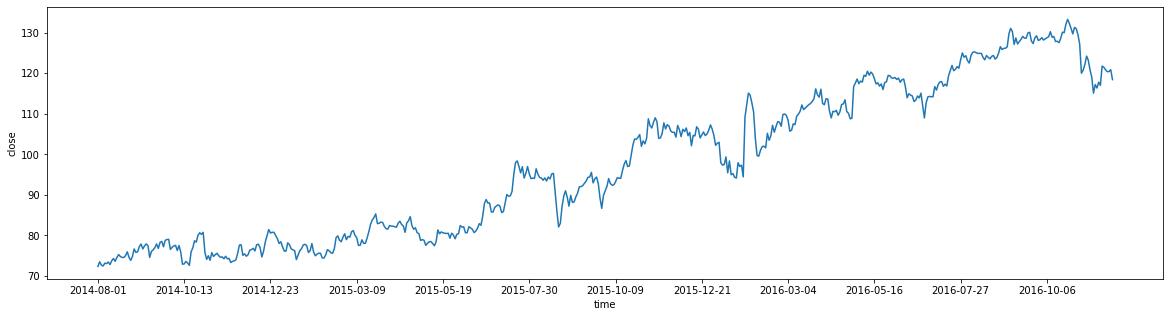

In [ ]:
sel_stock = 'FB'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## [ 1 ] ARIMA model

471 589
(471,) (118,) (589,)


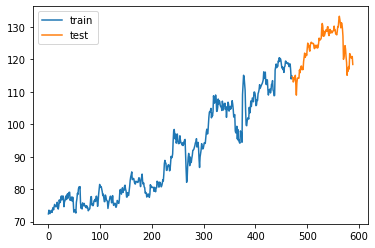

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  471
Model:                ARIMA(16, 2, 4)   Log Likelihood                -892.752
Date:                Tue, 04 May 2021   AIC                           1827.505
Time:                        23:00:59   BIC                           1914.668
Sample:                             0   HQIC                          1861.800
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3190      0.554     -2.382      0.017      -2.404      -0.234
ar.L2         -1.2917      0.437     -2.954      0.003      -2.149      -0.435
ar.L3         -0.5693      0.505     -1.127      0.2

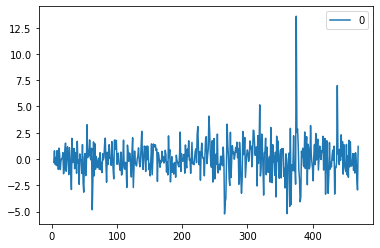

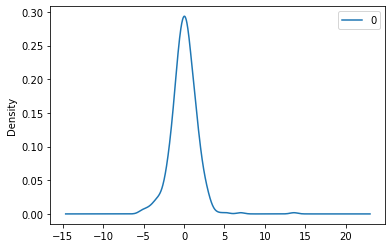

                0
count  468.000000
mean     0.028598
std      1.617635
min     -5.229810
25%     -0.822720
50%      0.046104
75%      0.927169
max     13.595235


In [ ]:
data = sel_pd[[xvar]].copy()
tr = int(.8*len(data))
print(tr,len(data))
drx,dex = data[0:tr], data[tr:]
ddrx, ddex,ddata = np.array(drx)[:,0], np.array(dex)[:,0], np.array(data)[:,0]

print(ddrx.shape, ddex.shape ,ddata.shape )

plt.plot(drx, label='train')
plt.plot(dex, label='test')
plt.legend()
plt.show()

ar_p, dif, ma_q = 16,2,4
arima_pdq = (ar_p, dif, ma_q)
model_ARIMA = ARIMA(endog=drx, order=arima_pdq)
result_ARIMA = model_ARIMA.fit()
print(result_ARIMA.summary())
# line plot of residuals
residuals = pd.DataFrame(result_ARIMA.resid)[dif+1:]
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Predict

(471,) (471,)


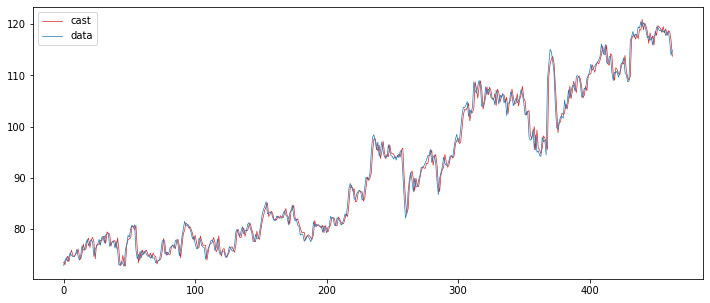

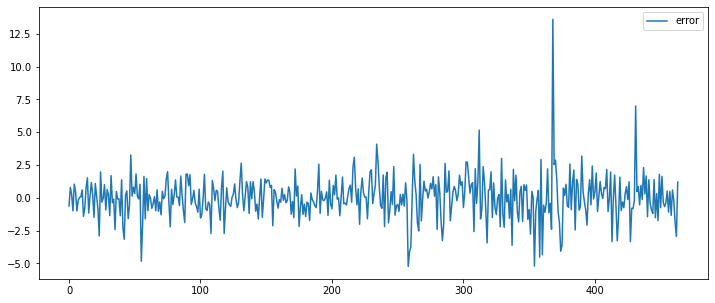

MSE: 2.6323913286530676


In [ ]:
output = result_ARIMA.predict( )
np_true = np.array(drx[xvar])
np_prd = np.array(output)
print(np_true.shape, np_prd.shape)
plt.figure(figsize=(12,5))
plt.plot(np_prd[7:], label='cast',color='tab:red', linewidth=0.7)
plt.plot(np_true[7:],label='data', linewidth=0.7)
plt.legend()
plt.show()


plt.figure(figsize=(12,5))
de = np_true[7:]-np_prd[7:]
plt.plot(de,label='error')
plt.legend()
plt.show()
print('MSE:',np.mean(de**2))



### Forecast (extend)

In [ ]:
fcc = []
derr = []
for i in range(len(ddrx), len(data)):
    resf = result_ARIMA.forecast()
    #print(resf,  i)
    fc = np.array( resf  )[0]
    #fcc.append([fc, ddex[i], fc-ddex[i]])
    #print('extend', ddata[i])
    fcc.append(fc)
    derr.append(ddata[i])
    result_ARIMA = result_ARIMA.extend( [ddata[i]] )
fccA = np.array(fcc)
derrA = np.array(derr)
print(fccA.shape,derrA.shape)


(118,) (118,)


### Forecast Plot

MSE: 2.509426781097748


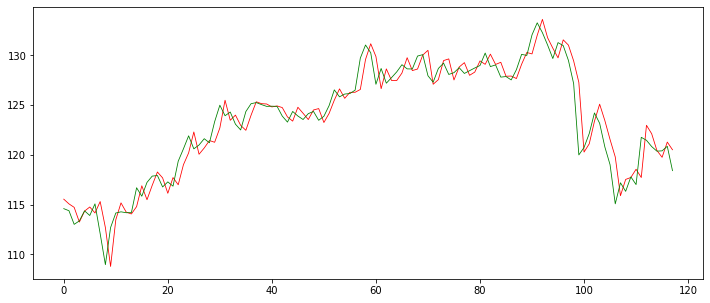

In [ ]:
#print(fccA.shape,ddata[tr:].shape)
plt.figure(figsize=(12,5))
#plt.plot(all_pred)
plt.plot(fccA,color='red',linewidth=0.8)
plt.plot(ddata[tr:],color='green',linewidth=0.8)
#plt.legend()
MSE = np.mean((fccA-derrA)**2)
print('MSE:',MSE)

### All Data Plot

(589,) (589,)
MSE: 2.6191203044376525


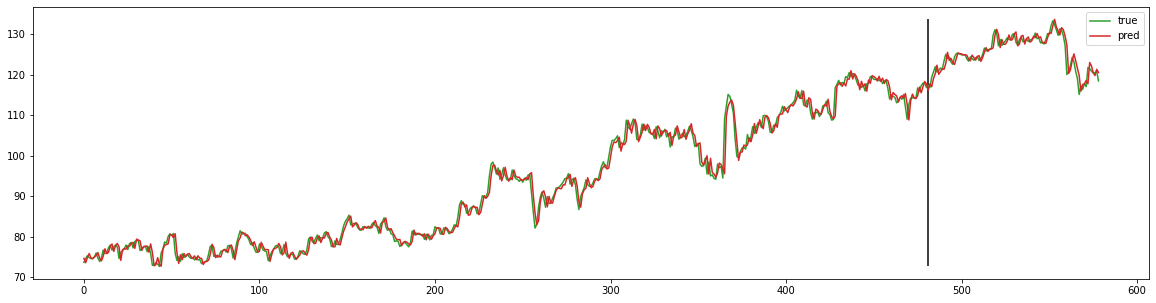

In [ ]:
#print(fccA.shape,ddata[tr:].shape)

all_pred = np.hstack((np_prd,fccA))
print(all_pred.shape,ddata.shape)
plt.figure(figsize=(20,5))
#plt.plot(all_pred)
plt.plot(ddata[10:],color='tab:green',label='true')
plt.plot(all_pred[10:],color='tab:red', label='pred')

plt.vlines(10+len(np_prd),np.min(all_pred[10:]),np.max(all_pred[10:]))
plt.legend()
MSE = np.mean((all_pred[10:]-ddata[10:])**2)
print('MSE:',MSE)

## [ 2 ] LSTM

### Divide Timesteps

In [ ]:
df= sel_pd
print('Number of rows and columns:', df.shape)
df.head(5)
N = len(df)
tr = int(N*0.80)
print(N,tr,N-tr)
timesteps = 20
print('Time-Steps:',timesteps)

training_set = df.iloc[:tr, 1:2].values
test_set = df.iloc[tr:, 1:2].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(timesteps, tr):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)
print('Final shape:',X_train.shape,y_train.shape)

Number of rows and columns: (589, 7)
589 471 118
Time-Steps: 20
Final shape: (451, 20, 1) (451,)


### Model Build

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
print(model.summary())

cb_ES_loss = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  #monitor: Quantity to be monitored.
        min_delta=0.001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=25,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )


cb_list = [cb_ES_loss]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 20, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

### Model Train

Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
0.004343862179666758


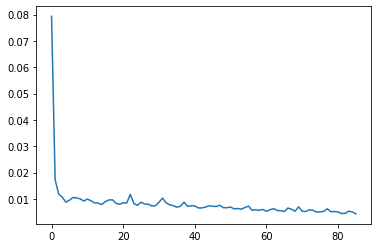

In [ ]:
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0, callbacks=cb_list)
plt.plot(hist.history['loss'])
print(hist.history['loss'][-1])

### Prepare Test

In [ ]:
dataset_train = df.iloc[:tr, 1:2]
dataset_test = df.iloc[tr:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, N-tr):
    X_test.append(inputs[i-timesteps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)


(58, 20, 1)


### Eval Loss

In [ ]:
model.evaluate(X_test, y_test,verbose=1)
predicted_stock_price = model.predict(X_test)[:,0]
predicted_stock_price1 = model.predict(X_train)[:,0]
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 2s 12ms/step - loss: 0.0017


### Predict

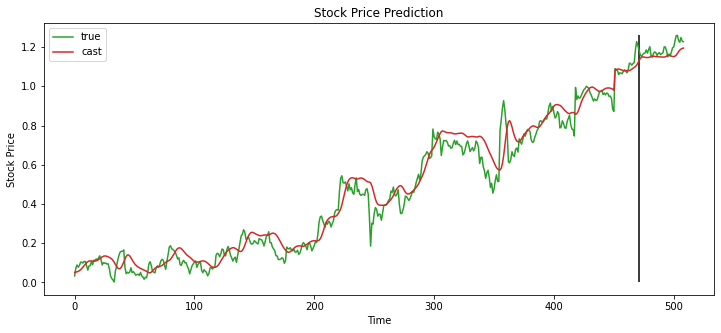

MSE: 0.004253058375043456


In [ ]:

y_g = np.hstack((y_train,y_test))
y_p = np.hstack((predicted_stock_price1,predicted_stock_price))

plt.figure(figsize=(12,5))
plt.plot(y_g, color = 'tab:green', label = 'true')
plt.plot(y_p, color = 'tab:red', label = 'cast')
plt.vlines(tr,0,np.max(y_g))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

MSE = np.mean((y_g - y_p)**2)
print('MSE:', MSE)

## [ 3 ] Prophet

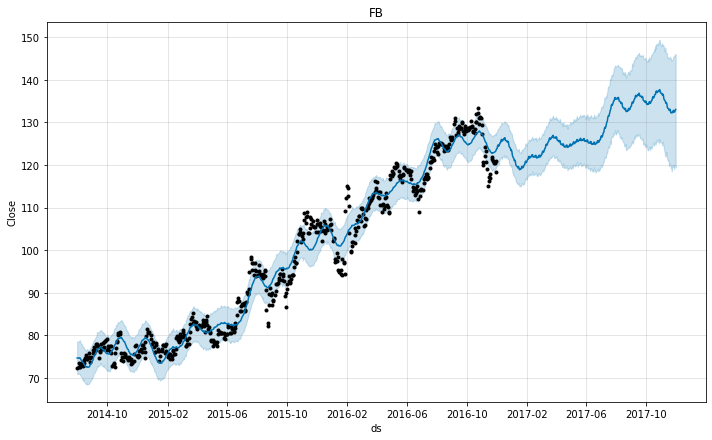

In [ ]:
data = sel_pd[["Date",xvar]]
data = data.rename(columns = {"Date":"ds",xvar:"y"})
m = Prophet(daily_seasonality = True)
m.fit(data) 
future = m.make_future_dataframe(periods=365) 
prediction = m.predict(future)
m.plot(prediction)
plt.title(sel_stock)
plt.ylabel("Close")
plt.show()



---



# Stock Select : AAPL

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         Date       High        Low  ...      Close       Volume  Adj Close
0  2014-08-01  24.155001  23.702499  ...  24.032499  194044000.0  21.657644
1  2014-08-04  24.145000  23.792500  ...  23.897499  159832000.0  21.535982
2  2014-08-05  23.920000  23.590000  ...  23.780001  223732000.0  21.430096

[3 rows x 7 columns]
AAPL 589


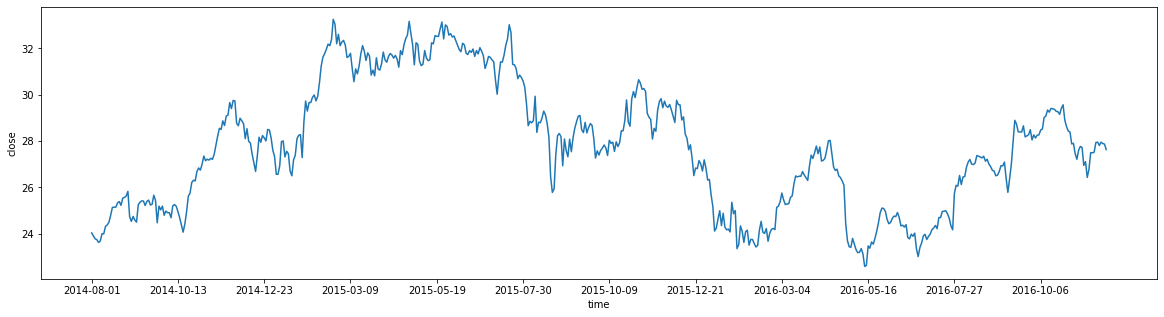

In [ ]:
sel_stock = 'AAPL'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## [ 1 ] ARIMA model

471 589
(471,) (118,) (589,)


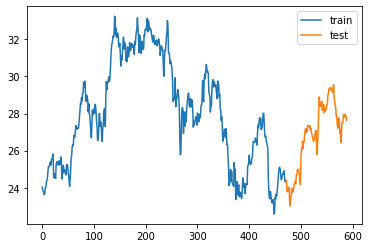

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  471
Model:                ARIMA(14, 2, 1)   Log Likelihood                -287.649
Date:                Tue, 04 May 2021   AIC                            607.298
Time:                        23:06:42   BIC                            673.708
Sample:                             0   HQIC                           633.428
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0010      0.043     -0.023      0.982      -0.086       0.084
ar.L2         -0.0517      0.050     -1.038      0.299      -0.149       0.046
ar.L3         -0.0041      0.044     -0.094      0.9

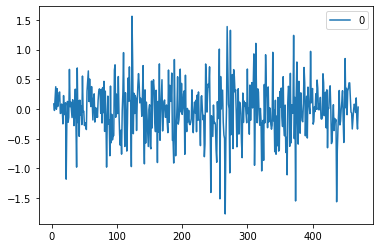

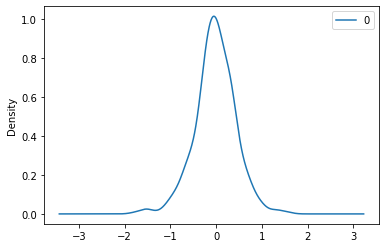

                0
count  468.000000
mean    -0.019219
std      0.445974
min     -1.765808
25%     -0.246412
50%     -0.013691
75%      0.270194
max      1.562052


In [ ]:
data = sel_pd[[xvar]].copy()
tr = int(.8*len(data))
print(tr,len(data))
drx,dex = data[0:tr], data[tr:]
ddrx, ddex,ddata = np.array(drx)[:,0], np.array(dex)[:,0], np.array(data)[:,0]

print(ddrx.shape, ddex.shape ,ddata.shape )

plt.plot(drx, label='train')
plt.plot(dex, label='test')
plt.legend()
plt.show()

ar_p, dif, ma_q = 14,2,1
arima_pdq = (ar_p, dif, ma_q)
model_ARIMA = ARIMA(endog=drx, order=arima_pdq)
result_ARIMA = model_ARIMA.fit()
print(result_ARIMA.summary())
# line plot of residuals
residuals = pd.DataFrame(result_ARIMA.resid)[dif+1:]
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Predict

(471,) (471,)


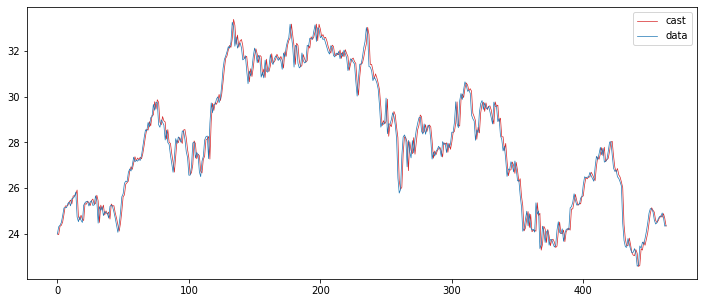

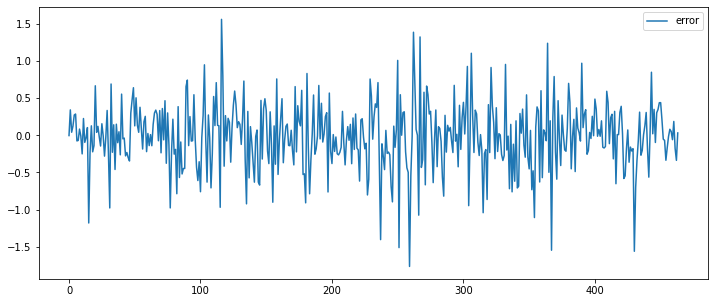

MSE: 0.20016824048580842


In [ ]:
output = result_ARIMA.predict( )
np_true = np.array(drx[xvar])
np_prd = np.array(output)
print(np_true.shape, np_prd.shape)
plt.figure(figsize=(12,5))
plt.plot(np_prd[7:], label='cast',color='tab:red', linewidth=0.7)
plt.plot(np_true[7:],label='data', linewidth=0.7)
plt.legend()
plt.show()


plt.figure(figsize=(12,5))
de = np_true[7:]-np_prd[7:]
plt.plot(de,label='error')
plt.legend()
plt.show()
print('MSE:',np.mean(de**2))



### Forecast (extend)

In [ ]:
fcc = []
derr = []
for i in range(len(ddrx), len(data)):
    resf = result_ARIMA.forecast()
    #print(resf,  i)
    fc = np.array( resf  )[0]
    #fcc.append([fc, ddex[i], fc-ddex[i]])
    #print('extend', ddata[i])
    fcc.append(fc)
    derr.append(ddata[i])
    result_ARIMA = result_ARIMA.extend( [ddata[i]] )
fccA = np.array(fcc)
derrA = np.array(derr)
print(fccA.shape,derrA.shape)


(118,) (118,)


### Forecast Plot

MSE: 0.11616313902972523


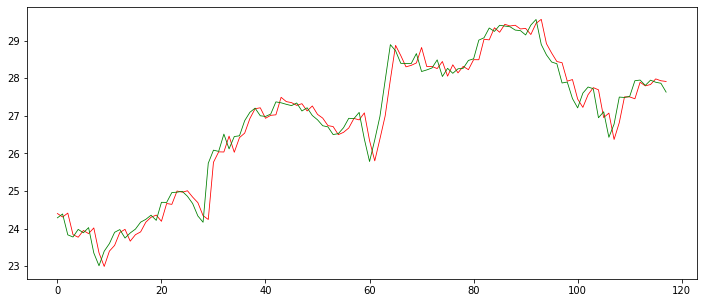

In [ ]:
#print(fccA.shape,ddata[tr:].shape)
plt.figure(figsize=(12,5))
#plt.plot(all_pred)
plt.plot(fccA,color='red',linewidth=0.8)
plt.plot(ddata[tr:],color='green',linewidth=0.8)
#plt.legend()
MSE = np.mean((fccA-derrA)**2)
print('MSE:',MSE)

### All Data Plot

(589,) (589,)
MSE: 0.1838793093284033


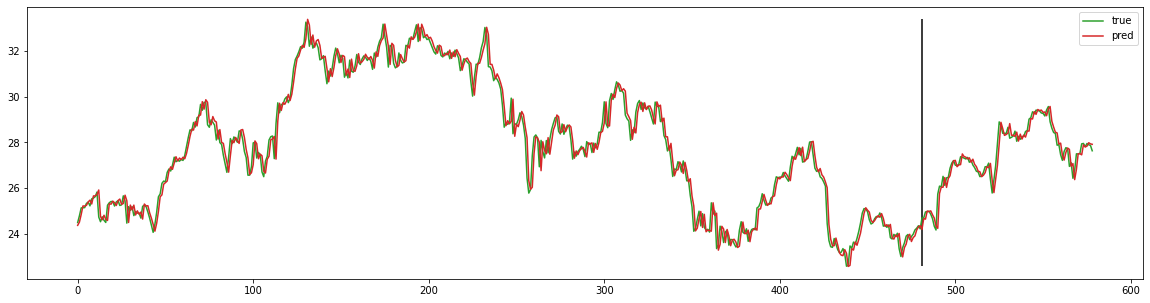

In [ ]:
#print(fccA.shape,ddata[tr:].shape)

all_pred = np.hstack((np_prd,fccA))
print(all_pred.shape,ddata.shape)
plt.figure(figsize=(20,5))
#plt.plot(all_pred)
plt.plot(ddata[10:],color='tab:green',label='true')
plt.plot(all_pred[10:],color='tab:red', label='pred')

plt.vlines(10+len(np_prd),np.min(all_pred[10:]),np.max(all_pred[10:]))
plt.legend()
MSE = np.mean((all_pred[10:]-ddata[10:])**2)
print('MSE:',MSE)

## [ 2 ] LSTM

### Divide Timesteps

In [ ]:
df= sel_pd
print('Number of rows and columns:', df.shape)
df.head(5)
N = len(df)
tr = int(N*0.80)
print(N,tr,N-tr)
timesteps = 20
print('Time-Steps:',timesteps)

training_set = df.iloc[:tr, 1:2].values
test_set = df.iloc[tr:, 1:2].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(timesteps, tr):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)
print('Final shape:',X_train.shape,y_train.shape)

Number of rows and columns: (589, 7)
589 471 118
Time-Steps: 20
Final shape: (451, 20, 1) (451,)


### Model Build

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
print(model.summary())

cb_ES_loss = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  #monitor: Quantity to be monitored.
        min_delta=0.001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=25,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )


cb_list = [cb_ES_loss]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

### Model Train

Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
0.0059554013423621655


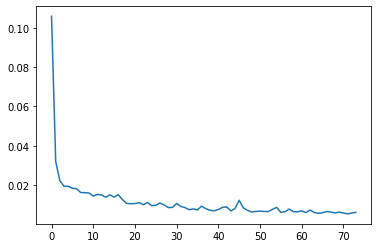

In [ ]:
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0, callbacks=cb_list)
plt.plot(hist.history['loss'])
print(hist.history['loss'][-1])

### Prepare Test

In [ ]:
dataset_train = df.iloc[:tr, 1:2]
dataset_test = df.iloc[tr:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, N-tr):
    X_test.append(inputs[i-timesteps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)


(58, 20, 1)


### Eval Loss

In [ ]:
model.evaluate(X_test, y_test,verbose=1)
predicted_stock_price = model.predict(X_test)[:,0]
predicted_stock_price1 = model.predict(X_train)[:,0]
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 13ms/step - loss: 0.0032


### Predict

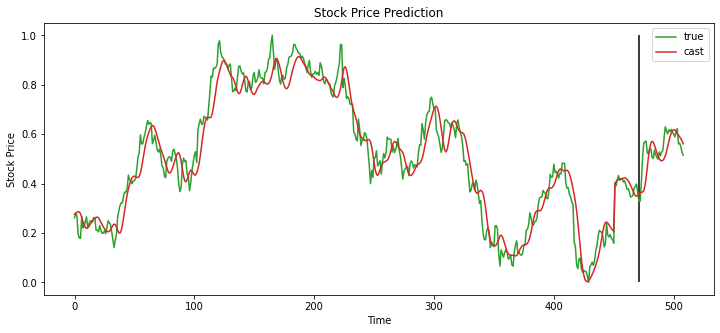

MSE: 0.004072078693090138


In [ ]:

y_g = np.hstack((y_train,y_test))
y_p = np.hstack((predicted_stock_price1,predicted_stock_price))

plt.figure(figsize=(12,5))
plt.plot(y_g, color = 'tab:green', label = 'true')
plt.plot(y_p, color = 'tab:red', label = 'cast')
plt.vlines(tr,0,np.max(y_g))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

MSE = np.mean((y_g - y_p)**2)
print('MSE:', MSE)

## [ 3 ] Prophet

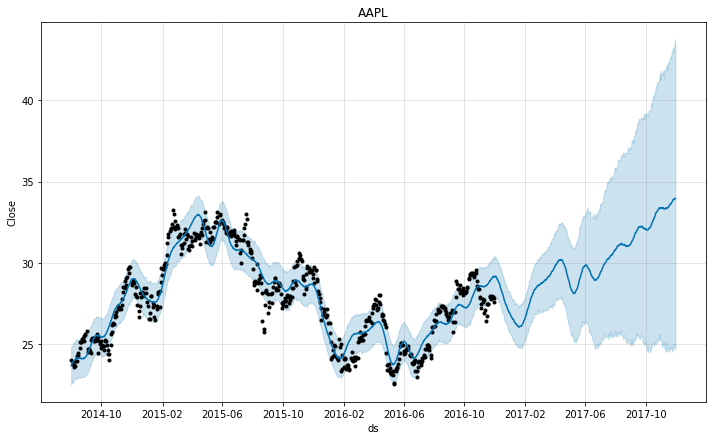

In [ ]:
data = sel_pd[["Date",xvar]]
data = data.rename(columns = {"Date":"ds",xvar:"y"})
m = Prophet(daily_seasonality = True)
m.fit(data) 
future = m.make_future_dataframe(periods=365) 
prediction = m.predict(future)
m.plot(prediction)
plt.title(sel_stock)
plt.ylabel("Close")
plt.show()



---



# Stock Select : IBM

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         Date        High         Low  ...       Close     Volume   Adj Close
0  2014-08-01  191.500000  188.860001  ...  189.149994  5181100.0  143.561371
1  2014-08-04  189.949997  188.600006  ...  189.639999  2125900.0  143.933304
2  2014-08-05  189.199997  186.440002  ...  187.100006  3307900.0  142.005493

[3 rows x 7 columns]
IBM 589


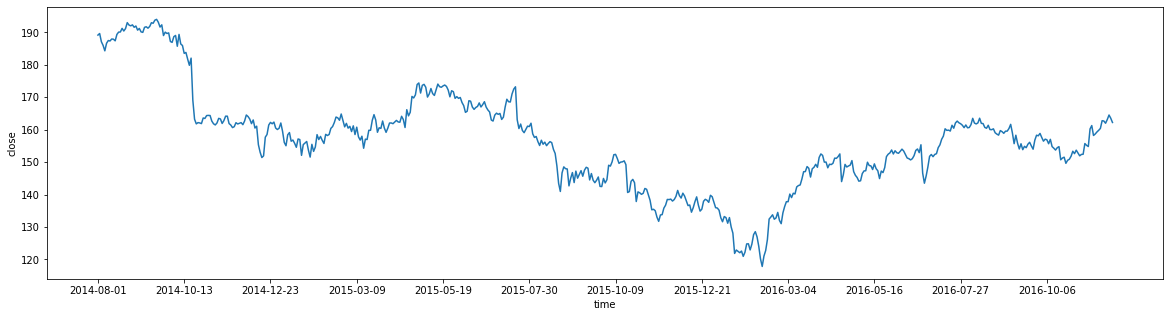

In [ ]:
sel_stock = 'IBM'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## [ 1 ] ARIMA model

471 589
(471,) (118,) (589,)


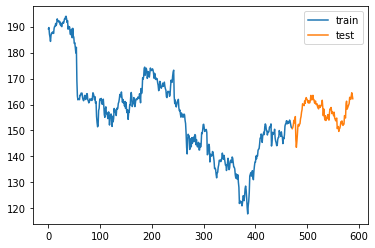

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  471
Model:                ARIMA(19, 2, 1)   Log Likelihood                -997.536
Date:                Tue, 04 May 2021   AIC                           2037.072
Time:                        23:10:55   BIC                           2124.235
Sample:                             0   HQIC                          2071.368
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0169      0.040      0.424      0.672      -0.061       0.095
ar.L2         -0.0679      0.048     -1.417      0.156      -0.162       0.026
ar.L3          0.0378      0.052      0.734      0.4

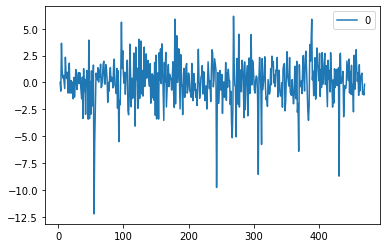

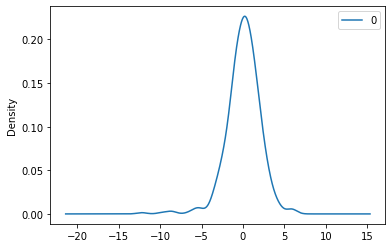

                0
count  468.000000
mean     0.068058
std      2.026281
min    -12.214146
25%     -0.985047
50%      0.183405
75%      1.254700
max      6.157767


In [ ]:
data = sel_pd[[xvar]].copy()
tr = int(.8*len(data))
print(tr,len(data))
drx,dex = data[0:tr], data[tr:]
ddrx, ddex,ddata = np.array(drx)[:,0], np.array(dex)[:,0], np.array(data)[:,0]

print(ddrx.shape, ddex.shape ,ddata.shape )

plt.plot(drx, label='train')
plt.plot(dex, label='test')
plt.legend()
plt.show()

ar_p, dif, ma_q = 19,2,1
arima_pdq = (ar_p, dif, ma_q)
model_ARIMA = ARIMA(endog=drx, order=arima_pdq)
result_ARIMA = model_ARIMA.fit()
print(result_ARIMA.summary())
# line plot of residuals
residuals = pd.DataFrame(result_ARIMA.resid)[dif+1:]
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Predict

(471,) (471,)


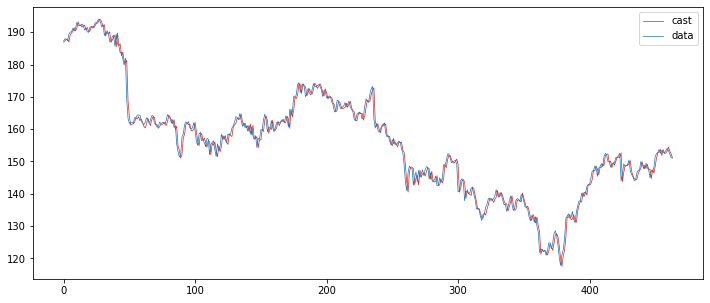

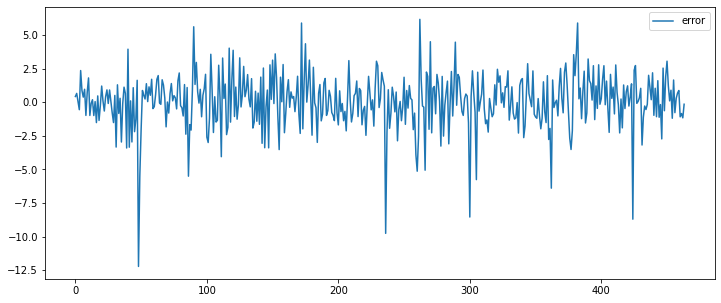

MSE: 4.104090029213578


In [ ]:
output = result_ARIMA.predict( )
np_true = np.array(drx[xvar])
np_prd = np.array(output)
print(np_true.shape, np_prd.shape)
plt.figure(figsize=(12,5))
plt.plot(np_prd[7:], label='cast',color='tab:red', linewidth=0.7)
plt.plot(np_true[7:],label='data', linewidth=0.7)
plt.legend()
plt.show()


plt.figure(figsize=(12,5))
de = np_true[7:]-np_prd[7:]
plt.plot(de,label='error')
plt.legend()
plt.show()
print('MSE:',np.mean(de**2))



### Forecast (extend)

In [ ]:
fcc = []
derr = []
for i in range(len(ddrx), len(data)):
    resf = result_ARIMA.forecast()
    #print(resf,  i)
    fc = np.array( resf  )[0]
    #fcc.append([fc, ddex[i], fc-ddex[i]])
    #print('extend', ddata[i])
    fcc.append(fc)
    derr.append(ddata[i])
    result_ARIMA = result_ARIMA.extend( [ddata[i]] )
fccA = np.array(fcc)
derrA = np.array(derr)
print(fccA.shape,derrA.shape)


(118,) (118,)


### Forecast Plot

MSE: 2.818676287174192


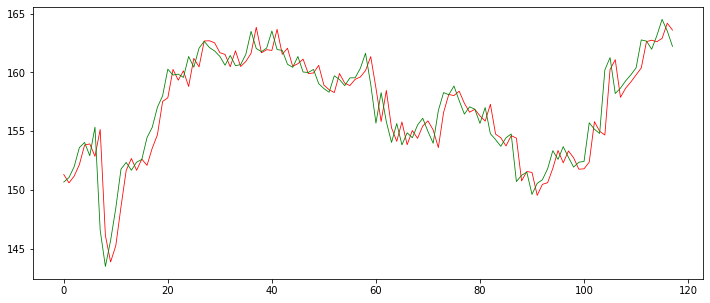

In [ ]:
#print(fccA.shape,ddata[tr:].shape)
plt.figure(figsize=(12,5))
#plt.plot(all_pred)
plt.plot(fccA,color='red',linewidth=0.8)
plt.plot(ddata[tr:],color='green',linewidth=0.8)
#plt.legend()
MSE = np.mean((fccA-derrA)**2)
print('MSE:',MSE)

### All Data Plot

(589,) (589,)
MSE: 3.8623382631115564


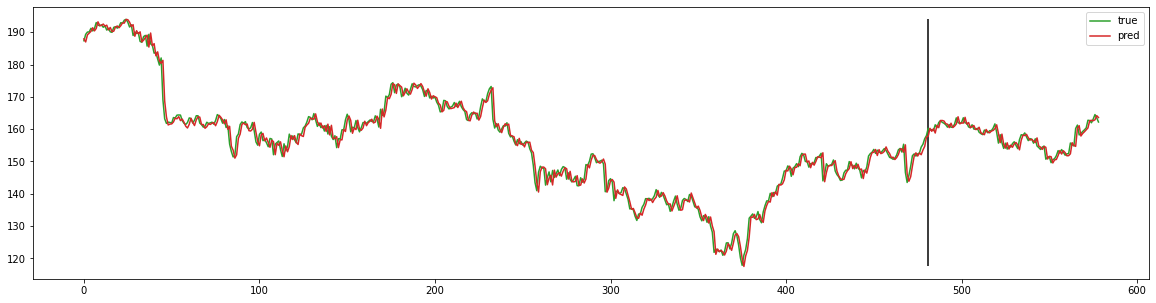

In [ ]:
#print(fccA.shape,ddata[tr:].shape)

all_pred = np.hstack((np_prd,fccA))
print(all_pred.shape,ddata.shape)
plt.figure(figsize=(20,5))
#plt.plot(all_pred)
plt.plot(ddata[10:],color='tab:green',label='true')
plt.plot(all_pred[10:],color='tab:red', label='pred')

plt.vlines(10+len(np_prd),np.min(all_pred[10:]),np.max(all_pred[10:]))
plt.legend()
MSE = np.mean((all_pred[10:]-ddata[10:])**2)
print('MSE:',MSE)

## [ 2 ] LSTM

### Divide Timesteps

In [ ]:
df= sel_pd
print('Number of rows and columns:', df.shape)
df.head(5)
N = len(df)
tr = int(N*0.80)
print(N,tr,N-tr)
timesteps = 20
print('Time-Steps:',timesteps)

training_set = df.iloc[:tr, 1:2].values
test_set = df.iloc[tr:, 1:2].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(timesteps, tr):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)
print('Final shape:',X_train.shape,y_train.shape)

Number of rows and columns: (589, 7)
589 471 118
Time-Steps: 20
Final shape: (451, 20, 1) (451,)


### Model Build

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
print(model.summary())

cb_ES_loss = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  #monitor: Quantity to be monitored.
        min_delta=0.001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=25,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )


cb_list = [cb_ES_loss]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)               

### Model Train

Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping
0.0036899822298437357


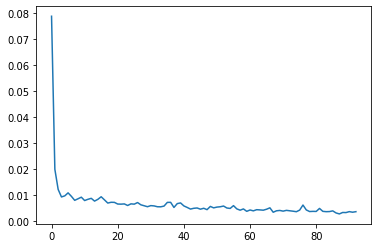

In [ ]:
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0, callbacks=cb_list)
plt.plot(hist.history['loss'])
print(hist.history['loss'][-1])

### Prepare Test

In [ ]:
dataset_train = df.iloc[:tr, 1:2]
dataset_test = df.iloc[tr:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, N-tr):
    X_test.append(inputs[i-timesteps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)


(58, 20, 1)


### Eval Loss

In [ ]:
model.evaluate(X_test, y_test,verbose=1)
predicted_stock_price = model.predict(X_test)[:,0]
predicted_stock_price1 = model.predict(X_train)[:,0]
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 14ms/step - loss: 0.0011


### Predict

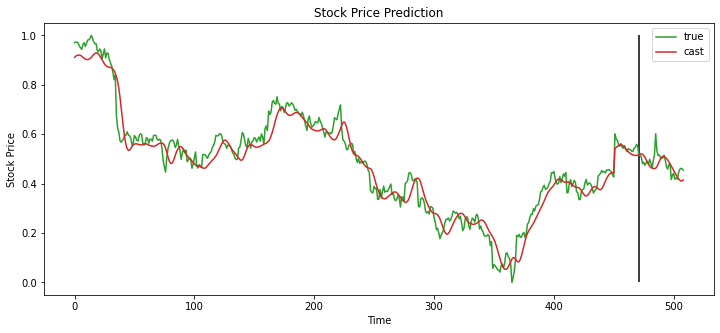

MSE: 0.0022730881078532957


In [ ]:

y_g = np.hstack((y_train,y_test))
y_p = np.hstack((predicted_stock_price1,predicted_stock_price))

plt.figure(figsize=(12,5))
plt.plot(y_g, color = 'tab:green', label = 'true')
plt.plot(y_p, color = 'tab:red', label = 'cast')
plt.vlines(tr,0,np.max(y_g))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

MSE = np.mean((y_g - y_p)**2)
print('MSE:', MSE)

## [ 3 ] Prophet

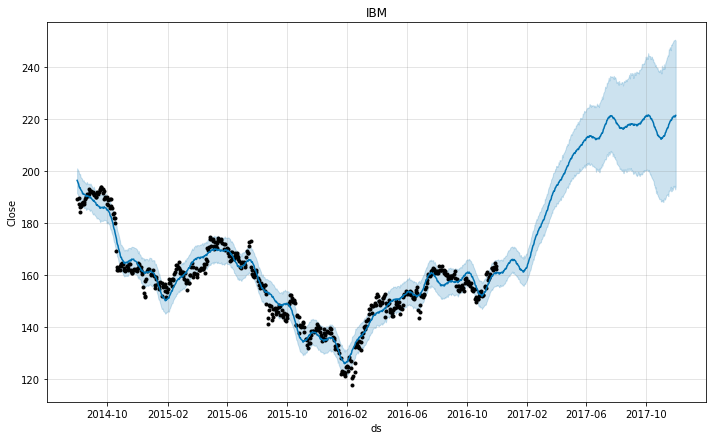

In [ ]:
data = sel_pd[["Date",xvar]]
data = data.rename(columns = {"Date":"ds",xvar:"y"})
m = Prophet(daily_seasonality = True)
m.fit(data) 
future = m.make_future_dataframe(periods=365) 
prediction = m.predict(future)
m.plot(prediction)
plt.title(sel_stock)
plt.ylabel("Close")
plt.show()



---



# Stock Select : GOOGL

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         Date        High         Low  ...       Close   Volume   Adj Close
0  2014-08-01  583.429993  570.299988  ...  573.599976  2213300  573.599976
1  2014-08-04  583.820007  572.260010  ...  582.270020  1519400  582.270020
2  2014-08-05  580.200012  570.309998  ...  573.140015  1643800  573.140015

[3 rows x 7 columns]
GOOGL 589


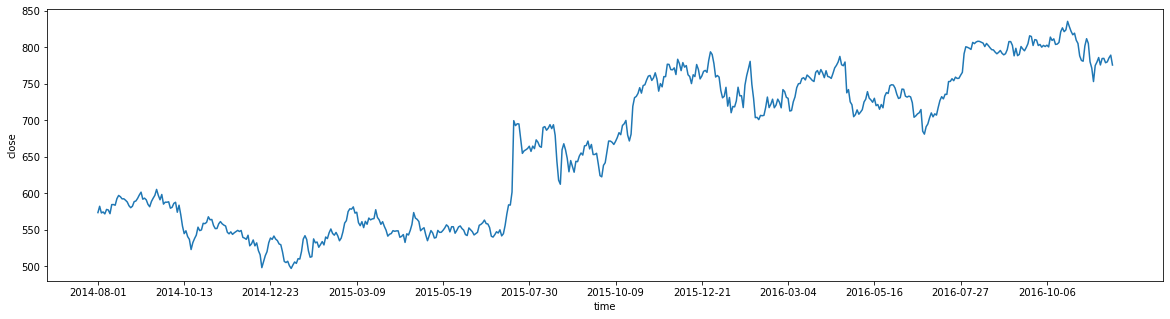

In [ ]:
sel_stock = 'GOOGL'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## [ 1 ] ARIMA model

471 589
(471,) (118,) (589,)


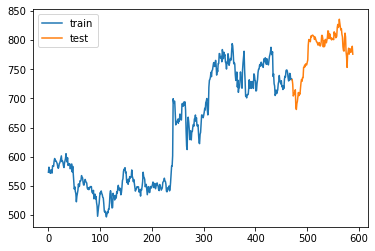

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  471
Model:                ARIMA(15, 2, 4)   Log Likelihood               -1753.776
Date:                Tue, 04 May 2021   AIC                           3547.553
Time:                        23:14:30   BIC                           3630.565
Sample:                             0   HQIC                          3580.215
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9836      0.104     -9.484      0.000      -1.187      -0.780
ar.L2         -0.8929      0.120     -7.441      0.000      -1.128      -0.658
ar.L3         -0.8764      0.098     -8.951      0.0

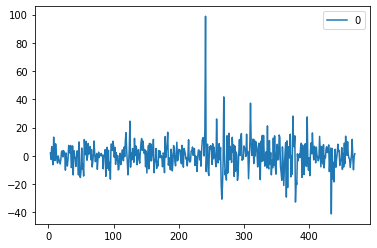

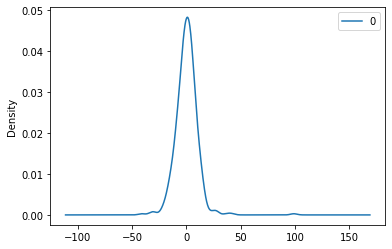

                0
count  468.000000
mean     0.241014
std     10.137460
min    -41.213833
25%     -4.684517
50%      0.312392
75%      5.238950
max     98.857461


In [ ]:
data = sel_pd[[xvar]].copy()
tr = int(.8*len(data))
print(tr,len(data))
drx,dex = data[0:tr], data[tr:]
ddrx, ddex,ddata = np.array(drx)[:,0], np.array(dex)[:,0], np.array(data)[:,0]

print(ddrx.shape, ddex.shape ,ddata.shape )

plt.plot(drx, label='train')
plt.plot(dex, label='test')
plt.legend()
plt.show()

ar_p, dif, ma_q = 15,2,4
arima_pdq = (ar_p, dif, ma_q)
model_ARIMA = ARIMA(endog=drx, order=arima_pdq)
result_ARIMA = model_ARIMA.fit()
print(result_ARIMA.summary())
# line plot of residuals
residuals = pd.DataFrame(result_ARIMA.resid)[dif+1:]
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Predict

(471,) (471,)


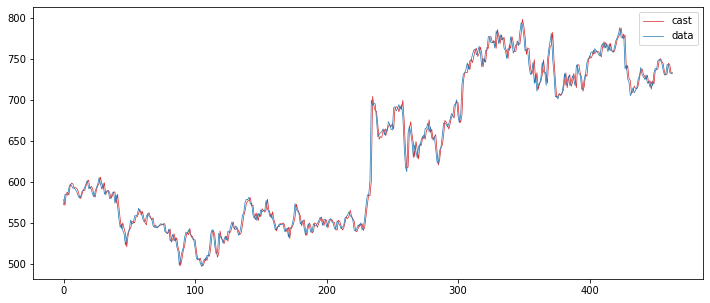

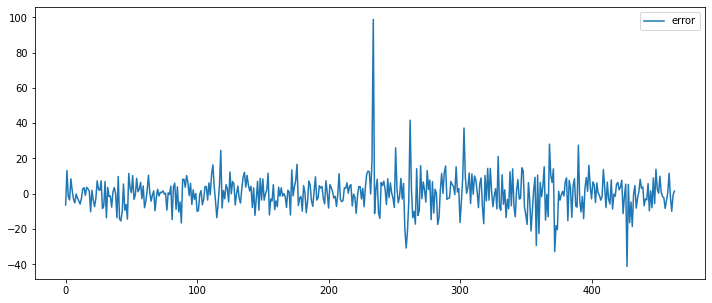

MSE: 103.36697496883654


In [ ]:
output = result_ARIMA.predict( )
np_true = np.array(drx[xvar])
np_prd = np.array(output)
print(np_true.shape, np_prd.shape)
plt.figure(figsize=(12,5))
plt.plot(np_prd[7:], label='cast',color='tab:red', linewidth=0.7)
plt.plot(np_true[7:],label='data', linewidth=0.7)
plt.legend()
plt.show()


plt.figure(figsize=(12,5))
de = np_true[7:]-np_prd[7:]
plt.plot(de,label='error')
plt.legend()
plt.show()
print('MSE:',np.mean(de**2))



### Forecast (extend)

In [ ]:
fcc = []
derr = []
for i in range(len(ddrx), len(data)):
    resf = result_ARIMA.forecast()
    #print(resf,  i)
    fc = np.array( resf  )[0]
    #fcc.append([fc, ddex[i], fc-ddex[i]])
    #print('extend', ddata[i])
    fcc.append(fc)
    derr.append(ddata[i])
    result_ARIMA = result_ARIMA.extend( [ddata[i]] )
fccA = np.array(fcc)
derrA = np.array(derr)
print(fccA.shape,derrA.shape)


(118,) (118,)


### Forecast Plot

MSE: 71.87272414618232


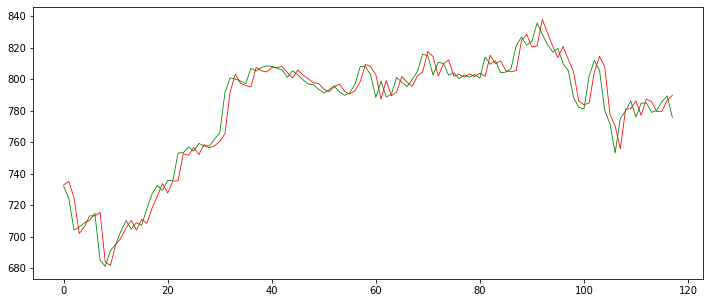

In [ ]:
#print(fccA.shape,ddata[tr:].shape)
plt.figure(figsize=(12,5))
#plt.plot(all_pred)
plt.plot(fccA,color='red',linewidth=0.8)
plt.plot(ddata[tr:],color='green',linewidth=0.8)
#plt.legend()
MSE = np.mean((fccA-derrA)**2)
print('MSE:',MSE)

### All Data Plot

(589,) (589,)
MSE: 97.10973296621866


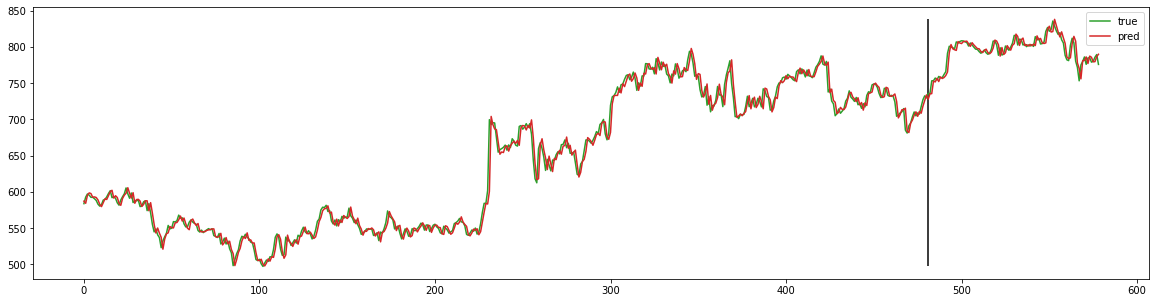

In [ ]:
#print(fccA.shape,ddata[tr:].shape)

all_pred = np.hstack((np_prd,fccA))
print(all_pred.shape,ddata.shape)
plt.figure(figsize=(20,5))
#plt.plot(all_pred)
plt.plot(ddata[10:],color='tab:green',label='true')
plt.plot(all_pred[10:],color='tab:red', label='pred')

plt.vlines(10+len(np_prd),np.min(all_pred[10:]),np.max(all_pred[10:]))
plt.legend()
MSE = np.mean((all_pred[10:]-ddata[10:])**2)
print('MSE:',MSE)

## [ 2 ] LSTM

### Divide Timesteps

In [ ]:
df= sel_pd
print('Number of rows and columns:', df.shape)
df.head(5)
N = len(df)
tr = int(N*0.80)
print(N,tr,N-tr)
timesteps = 20
print('Time-Steps:',timesteps)

training_set = df.iloc[:tr, 1:2].values
test_set = df.iloc[tr:, 1:2].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(timesteps, tr):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)
print('Final shape:',X_train.shape,y_train.shape)

Number of rows and columns: (589, 7)
589 471 118
Time-Steps: 20
Final shape: (451, 20, 1) (451,)


### Model Build

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
print(model.summary())

cb_ES_loss = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  #monitor: Quantity to be monitored.
        min_delta=0.001,  #min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=25,  #patience: Number of epochs with no improvement after which training will be stopped.
        verbose=1,  #verbose: verbosity mode.
        mode='auto',  #mode: One of {"auto", "min", "max"}. 
                      #In min mode, training will stop when the quantity monitored has stopped decreasing; 
                      #in "max" mode it will stop when the quantity monitored has stopped increasing; 
                      #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
        baseline=None,  #baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True #restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
        )


cb_list = [cb_ES_loss]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20, 50)            10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

### Model Train

0.004125045612454414


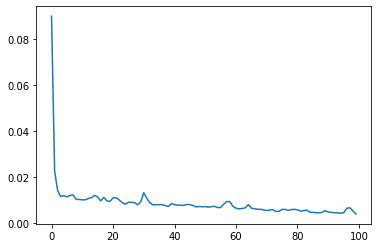

In [ ]:
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0, callbacks=cb_list)
plt.plot(hist.history['loss'])
print(hist.history['loss'][-1])

### Prepare Test

In [ ]:
dataset_train = df.iloc[:tr, 1:2]
dataset_test = df.iloc[tr:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, N-tr):
    X_test.append(inputs[i-timesteps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)


(58, 20, 1)


### Eval Loss

In [ ]:
model.evaluate(X_test, y_test,verbose=1)
predicted_stock_price = model.predict(X_test)[:,0]
predicted_stock_price1 = model.predict(X_train)[:,0]
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 12ms/step - loss: 0.0036


### Predict

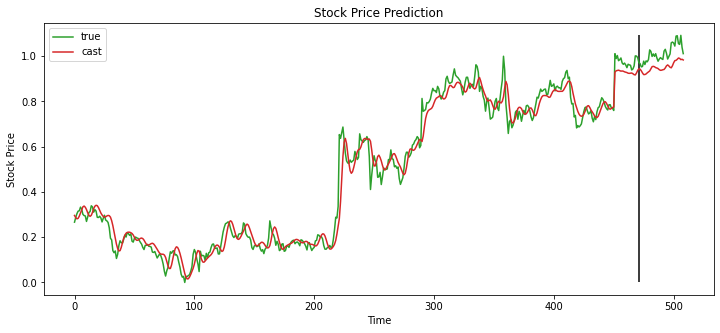

MSE: 0.0026719090381229064


In [ ]:

y_g = np.hstack((y_train,y_test))
y_p = np.hstack((predicted_stock_price1,predicted_stock_price))

plt.figure(figsize=(12,5))
plt.plot(y_g, color = 'tab:green', label = 'true')
plt.plot(y_p, color = 'tab:red', label = 'cast')
plt.vlines(tr,0,np.max(y_g))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

MSE = np.mean((y_g - y_p)**2)
print('MSE:', MSE)

## [ 3 ] Prophet

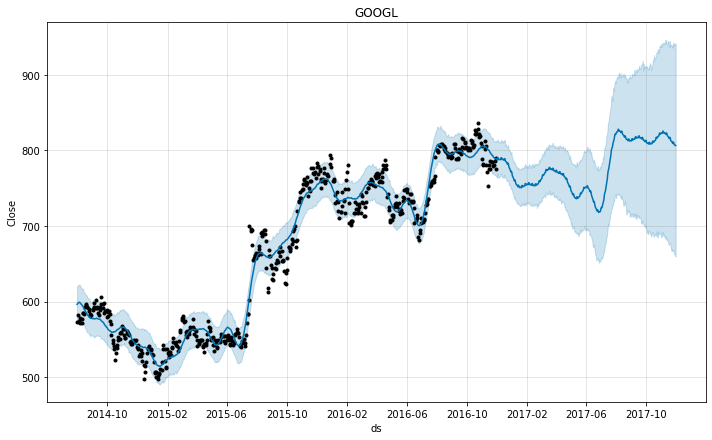

In [ ]:
data = sel_pd[["Date",xvar]]
data = data.rename(columns = {"Date":"ds",xvar:"y"})
m = Prophet(daily_seasonality = True)
m.fit(data) 
future = m.make_future_dataframe(periods=365) 
prediction = m.predict(future)
m.plot(prediction)
plt.title(sel_stock)
plt.ylabel("Close")
plt.show()



---

